Код для робота (менять не надо): 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


In [2]:
# PID_controller from https://en.wikipedia.org/wiki/PID_controller
# with value clipping https://en.wikipedia.org/wiki/Integral_windup 

MIN = -np.pi/4

class PID_Controller(object):
    def __init__(self, tau_p, tau_i, tau_d):
        self.tau_p = tau_p
        self.tau_i = tau_i
        self.tau_d = tau_d
        self.err = 0
        self.int = 0
    
    def steer(self, coordinates, dt=0.1):
        y, orientation = coordinates
        err = -y
        self.int += err * dt
        p_term = self.tau_p * err
        i_term = min(max(MIN, self.tau_i * self.int), -MIN)
        d_term = self.tau_d * (err - self.err) / dt
        self.err = err
        return p_term + i_term + d_term

Добавьте вычисление параметра steer через PID controller в этой клетке:

In [3]:
def run(robot, tau_p, tau_d, tau_i, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    controller = PID_Controller(tau_p, tau_i, tau_d)
    for i in range(n):
        cte = robot.y
        steer = controller.steer((robot.y, robot.orientation))
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

Запус и отрисовка траектории, тут нужно подобрать оптимальные параметры PID (сейчас стоят 1, 1, 1).

In [4]:
def plot(tau):
    robot = Robot()
    robot.set(0, 1, 0)

    x_trajectory, y_trajectory = run(robot, tau[0], tau[1], tau[2]) #тут нужно подобрать оптимальные параметры PID.

    plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
    plt.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')
    plt.legend()
    plt.show()

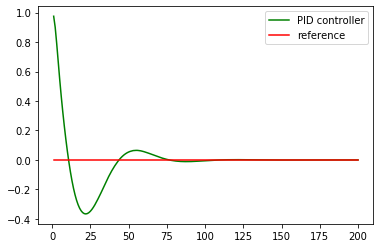

In [5]:
plot((1, 1, 1))

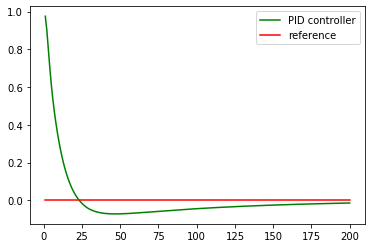

In [6]:
plot((1, 1, 0.1))

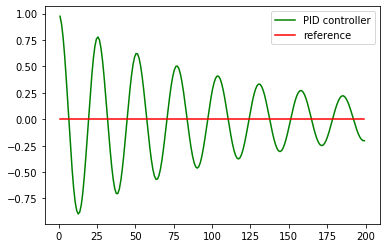

In [7]:
plot((1, 0.1, 0.1))

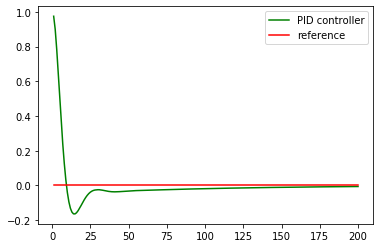

In [8]:
plot((1, 0.5, 0.1))

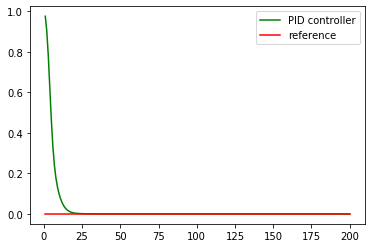

In [9]:
plot((2, 1, 0)) #optimal value 